In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, matthews_corrcoef
import seaborn as sns
sns.set()
from sklearn import metrics
import numpy as np
from brokenaxes import brokenaxes
from tqdm.notebook import tqdm

In [2]:
with open('model_outputs/HiRID/hirid_targets.pkl', 'rb') as f:
    targets = pickle.load(f)  # List of true labels

with open('model_outputs/HiRID/gru_hirid_model_outputs.pkl', 'rb') as f:
    gru_output = pickle.load(f)

with open('model_outputs/HiRID/lstm_hirid_model_outputs.pkl', 'rb') as f:
    lstm_output = pickle.load(f)  

with open('model_outputs/HiRID/tcn_hirid_model_outputs.pkl', 'rb') as f:
    tcn_output = pickle.load(f) 

with open('model_outputs/HiRID/tf_hirid_model_outputs.pkl', 'rb') as f:
    tf_output = pickle.load(f) 

with open('model_outputs/HiRID/hirid_GNN_baseline_model_outputs.pkl', 'rb') as f:
    gnnb0 = pickle.load(f) 
    
with open('model_outputs/HiRID/hirid_GNN_model_outputs.pkl', 'rb') as f:
    gnn_output = pickle.load(f) 

In [11]:
def mcc_f1_multiple_models(ground_truths, predicted_values_list, model_names):
    """
    Calculates MCC and F1 scores for multiple models.
    
    Parameters
    ----------
    ground_truths : numpy.ndarray
        True values.
    predicted_values_list : list of numpy.ndarray
        List of predicted values for different models.
    model_names : list of str
        List of model names.
    
    Returns
    -------
    results : dict
        Dictionary containing MCC, F1 scores, and thresholds for each model.
    """
    results = {}
    
    for predicted_values, model_name in zip(predicted_values_list, model_names):
        precision, recall, thresholds = metrics.precision_recall_curve(ground_truths, predicted_values)
        mcc = np.zeros(thresholds.shape)
        f1 = np.zeros(thresholds.shape)
        
        for index, T in enumerate(thresholds):
            predicted_values_after_cutoff = predicted_values > T
            mcc[index] = (metrics.matthews_corrcoef(ground_truths, predicted_values_after_cutoff) + 1) * 0.5
            f1[index] = metrics.f1_score(ground_truths, predicted_values_after_cutoff)
        
        results[model_name] = {'mcc': mcc, 'f1': f1, 'thresholds': thresholds}
    
    return results

In [12]:
def MCC_F1_Metric_multiple_models(results, W_num_of_subranges=100):
    """
    Computes the MCC-F1 metric and the best threshold for multiple models.
    
    Parameters
    ----------
    results : dict
        Dictionary containing MCC, F1 scores, and thresholds for each model.
    W_num_of_subranges : int, optional
        Number of subranges (default is 100).
    
    Returns
    -------
    metrics : dict
        Dictionary containing MCC-F1 metric and best threshold for each model.
    """
    metrics_results = {}
    
    for model_name, data in results.items():
        mcc, f1, thresholds = data['mcc'], data['f1'], data['thresholds']
        subrange_intervals = np.linspace(np.min(mcc), np.max(mcc), W_num_of_subranges)
        values_per_subrange = np.zeros_like(subrange_intervals)
        
        for i in range(W_num_of_subranges-1):
            for j in mcc:
                if j >= subrange_intervals[i] and j < subrange_intervals[i+1]:
                    values_per_subrange[i] = values_per_subrange[i] + 1
        
        Distance_of_points_within_subrange = np.sqrt(((mcc-1)**2) + ((f1-1)**2))
        sum_of_distance_within_subrange = np.zeros_like(subrange_intervals)
        index = -1
        
        for value in mcc:
            index += 1
            for i in range(W_num_of_subranges-1):
                if value >= subrange_intervals[i] and value < subrange_intervals[i+1]:
                    sum_of_distance_within_subrange[i] += Distance_of_points_within_subrange[index]
        
        mean_Distance_per_subrange = np.array(sum_of_distance_within_subrange / values_per_subrange)
        total_number_of_subranges = 0
        total_sum_of_mean_distances = 0
        
        for i in mean_Distance_per_subrange:
            if not np.isnan(i):
                total_number_of_subranges += 1
                total_sum_of_mean_distances += i
        
        grand_mean_distance = total_sum_of_mean_distances / total_number_of_subranges
        MCC_F1_Met = 1 - (grand_mean_distance / np.sqrt(2))
        
        result = np.where(Distance_of_points_within_subrange == Distance_of_points_within_subrange.min())
        Best_threshold = result[0][0]
        
        metrics_results[model_name] = {'MCC_F1_Met': MCC_F1_Met, 'Best_threshold': Best_threshold, 'threshold_value': thresholds[Best_threshold]}
    
    return metrics_results

In [13]:
def mcc_f1_multiple_models(ground_truths, predicted_values_list, model_names):
    """
    Calculates MCC and F1 scores for multiple models.
    
    Parameters
    ----------
    ground_truths : numpy.ndarray
        True values.
    predicted_values_list : list of numpy.ndarray
        List of predicted values for different models.
    model_names : list of str
        List of model names.
    
    Returns
    -------
    results : dict
        Dictionary containing MCC, F1 scores, and thresholds for each model.
    """
    results = {}
    
    for predicted_values, model_name in zip(predicted_values_list, model_names):
        precision, recall, th_main = metrics.precision_recall_curve(ground_truths, predicted_values)
        # precision, recall, thresholds = metrics.precision_recall_curve(ground_truths, predicted_values)
        thresholds = np.linspace(th_main.min(), th_main.max(), 1000)
        # print('thresolds are', len(thresholds))
        # print('min', min(thresholds), 'max', max(thresholds), thresholds[:20])
        mcc = np.zeros(thresholds.shape)
        f1 = np.zeros(thresholds.shape)
        
        for index, T in tqdm(enumerate(thresholds)):
            predicted_values_after_cutoff = predicted_values > T
            mcc[index] = (metrics.matthews_corrcoef(ground_truths, predicted_values_after_cutoff) + 1) * 0.5
            f1[index] = metrics.f1_score(ground_truths, predicted_values_after_cutoff)
        
        results[model_name] = {'mcc': mcc, 'f1': f1, 'thresholds': thresholds}

    
    return results

def MCC_F1_Metric_multiple_models(results, W_num_of_subranges=100):
    """
    Computes the MCC-F1 metric and the best threshold for multiple models.
    
    Parameters
    ----------
    results : dict
        Dictionary containing MCC, F1 scores, and thresholds for each model.
    W_num_of_subranges : int, optional
        Number of subranges (default is 100).
    
    Returns
    -------
    metrics : dict
        Dictionary containing MCC-F1 metric and best threshold for each model.
    """
    metrics_results = {}
    
    for model_name, data in results.items():
        mcc, f1, thresholds = data['mcc'], data['f1'], data['thresholds']
        subrange_intervals = np.linspace(np.min(mcc), np.max(mcc), W_num_of_subranges)
        values_per_subrange = np.zeros_like(subrange_intervals)
        
        for i in range(W_num_of_subranges-1):
            for j in mcc:
                if j >= subrange_intervals[i] and j < subrange_intervals[i+1]:
                    values_per_subrange[i] = values_per_subrange[i] + 1
        
        Distance_of_points_within_subrange = np.sqrt(((mcc-1)**2) + ((f1-1)**2))
        sum_of_distance_within_subrange = np.zeros_like(subrange_intervals)
        index = -1
        
        for value in mcc:
            index += 1
            for i in range(W_num_of_subranges-1):
                if value >= subrange_intervals[i] and value < subrange_intervals[i+1]:
                    sum_of_distance_within_subrange[i] += Distance_of_points_within_subrange[index]
        
        mean_Distance_per_subrange = np.array(sum_of_distance_within_subrange / values_per_subrange)
        total_number_of_subranges = 0
        total_sum_of_mean_distances = 0
        
        for i in mean_Distance_per_subrange:
            if not np.isnan(i):
                total_number_of_subranges += 1
                total_sum_of_mean_distances += i
        
        grand_mean_distance = total_sum_of_mean_distances / total_number_of_subranges
        MCC_F1_Met = 1 - (grand_mean_distance / np.sqrt(2))
        
        result = np.where(Distance_of_points_within_subrange == Distance_of_points_within_subrange.min())
        Best_threshold = result[0][0]
        
        metrics_results[model_name] = {'MCC_F1_Met': MCC_F1_Met, 'Best_threshold': Best_threshold, 'threshold_value': thresholds[Best_threshold]}
    
    return metrics_results

In [14]:
def plotting_models_comparison(results, metrics_results):
    """
    Generates a single plot for MCC and F1 scores for multiple models for comparison.
    
    Parameters
    ----------
    results : dict
        Dictionary containing MCC, F1 scores, and thresholds for each model.
    metrics_results : dict
        Dictionary containing MCC-F1 metric and best threshold for each model.
    """
    fig = plt.figure(figsize=(10, 10))
    bax = brokenaxes(ylims=((-0.01, 0.05), (0.45, 0.70), (0.98,1.02)), hspace=0.05)
    
    # colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for different models
    colors = plt.get_cmap('tab10').colors
    
    for idx, ((model_name, data), color) in enumerate(zip(results.items(), colors)):
        mcc, f1, thresholds = data['mcc'], data['f1'], data['thresholds']
        MCC_F1_Met = metrics_results[model_name]['MCC_F1_Met']
        Best_threshold = metrics_results[model_name]['Best_threshold']
        threshold_value = metrics_results[model_name]['threshold_value']
        
        bax.plot(f1, mcc, linewidth=2, alpha=0.8, color=color, label=f'{model_name}')
        bax.scatter(f1[Best_threshold], mcc[Best_threshold], color=color, s=100)
               
    # Annotate worst and perfect performance points
    bax.scatter(0, 0, color='black', linewidth=4)
    bax.annotate('Theoretical Worst performance', (0, 0), textcoords="offset points", xytext=(9, 2), ha='left', size=16)
    bax.scatter(1, 1, color='black', linewidth=4)
    bax.annotate('Theoretical Best performance', (1, 1), textcoords="offset points", xytext=(-9, 2), ha='right', size=16)

    bax.axhline(y=0.5, xmin=0.05, xmax=0.95, linewidth=2, color='k', linestyle='--')
    bax.annotate('Random prediction line', xy=(0, 0.5), xytext=(10, -20),
                color='k', xycoords='data', textcoords="offset points", va="bottom")
    
    bax.set_xlabel('F1 score', fontsize=14)
    bax.set_ylabel('unit−normalized MCC',fontsize=14)
    fig.suptitle('MCC-F1 curve',fontsize=14)
    
    # Customizing the plot
    bax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    bax.set_facecolor('white')
    
    for ax in bax.axs:
        # ax.set_facecolor('white')
        for spine in ax.spines.values():
            spine.set_visible(False)
    
    bax.legend(loc='upper left', fontsize=14, bbox_to_anchor=(0.1, 0.85), title='Models', title_fontsize=14, fancybox=True, framealpha=1.0, facecolor='white')
    
    # plt.tight_layout()
    
    plt.show()
    # plt.savefig('f1mcc.png', dpi=600, bbox_inches='tight', pad_inches=0.1)

In [15]:
y_true = np.asarray(targets)
y_pred1= np.asarray(gru_output)
y_pred2= np.asarray(lstm_output)
y_pred3= np.asarray(tcn_output)
y_pred4= np.asarray(tf_output)
y_pred5= np.asarray(gnnb0)
y_pred6= np.asarray(gnn_output)

In [16]:
# y_true=np.asarray(targets)

In [17]:
y_true.shape,y_pred1.shape, y_pred2.shape, y_pred3.shape, y_pred4.shape, y_pred5.shape

((1015139,), (1015139,), (1015139,), (1015139,), (1015139,), (1015139,))

In [ ]:
ground_truths = y_true # Your true values
predicted_values_list = [y_pred1, y_pred2, y_pred3, y_pred4, y_pred5, y_pred6] 
# predicted_values_list = [y_pred5] 
                         #np.array([...]), np.array([...]), np.array([...])
                        # ]  # Predictions from 5 models

model_names = ['GRU', 'LSTM', 'TCN', 'TF', 'GNN b0', 'GNN dae']
# model_names = ['GNN b0']

# Calculate MCC and F1 scores
results = mcc_f1_multiple_models(ground_truths, predicted_values_list, model_names)

### the above calculation takes a while to calculate hence its saved as a pkl for reproduction

In [ ]:
### save these results to pickle

In [28]:
# with open('f1mcc_1000threshold_results_hirid_final.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [18]:
# Load the data from the pickle file
with open('model_outputs/HiRID/f1mcc_1000threshold_results_hirid_final.pkl', 'rb') as f:
    results = pickle.load(f)

In [19]:
## join both df

In [20]:
# final_results = results_old | results

In [21]:
final_results = results

In [22]:
# Compute MCC-F1 metrics
metrics_results = MCC_F1_Metric_multiple_models(final_results)

/tmp/ipykernel_623866/1891917873.py:78: RuntimeWarning: invalid value encountered in divide
  mean_Distance_per_subrange = np.array(sum_of_distance_within_subrange / values_per_subrange)


In [23]:
metrics_results

{'GRU': {'MCC_F1_Met': 0.40826479155187734,
  'Best_threshold': 312,
  'threshold_value': 0.2991407973350616},
 'LSTM': {'MCC_F1_Met': 0.40286455863368265,
  'Best_threshold': 344,
  'threshold_value': 0.31839330590612536},
 'TCN': {'MCC_F1_Met': 0.410667766980539,
  'Best_threshold': 340,
  'threshold_value': 0.33931876305539616},
 'TF': {'MCC_F1_Met': 0.4179551136288472,
  'Best_threshold': 350,
  'threshold_value': 0.3362830222795929},
 'GNN b0': {'MCC_F1_Met': 0.45612878287446923,
  'Best_threshold': 386,
  'threshold_value': 0.3863840379291861},
 'GNN dae': {'MCC_F1_Met': 0.5002120266942964,
  'Best_threshold': 389,
  'threshold_value': 0.38938934297055694}}

In [24]:
# Rename mapping
rename_mapping = {
    'TF': 'Transformer',
    'GNN dae': 'STGNN-DAE',
    # 'GNN b0': 'STGNN-Baseline'
    'GNN b0': 'STGNN-Base'
}

# Desired new order with renamed keys
# new_order = ['LSTM', 'GRU', 'TCN', 'Transformer', 'STGNN-Baseline', 'STGNN-DAE']
new_order = ['LSTM', 'GRU', 'TCN', 'Transformer', 'STGNN-Base', 'STGNN-DAE']

# Reverse mapping to find original keys for lookup
reverse_mapping = {v: k for k, v in rename_mapping.items()}

# Rename and reorder
reordered_dict = {
    key: final_results[reverse_mapping.get(key, key)]
    for key in new_order
}

# print(reordered_dict)

In [25]:
metrics_results = MCC_F1_Metric_multiple_models(reordered_dict)

/tmp/ipykernel_623866/1891917873.py:78: RuntimeWarning: invalid value encountered in divide
  mean_Distance_per_subrange = np.array(sum_of_distance_within_subrange / values_per_subrange)


In [26]:
def plotting_models_comparison(results, metrics_results):
    """
    Generates a single plot for MCC and F1 scores for multiple models for comparison.
    
    Parameters
    ----------
    results : dict
        Dictionary containing MCC, F1 scores, and thresholds for each model.
    metrics_results : dict
        Dictionary containing MCC-F1 metric and best threshold for each model.
    """
    fig = plt.figure(figsize=(8, 8))
    bax = brokenaxes(ylims=((-0.01, 0.05), (0.45, 0.70), (0.95,1.02)),xlims=((-0.01, 0.7),(0.95, 1.02),), hspace=0.1, wspace=0.1, width_ratios=[19,1], height_ratios=[1,9,1])
    
    # colors = ['b', 'g', 'r', 'c', 'm']  # Define a list of colors for different models
    # colors = plt.get_cmap('tab10').colors
    colors = ['#a6611a', '#dfc27d', '#80cdc1', '#018571', '#ca0020', '#5e3c99']
    
    for idx, ((model_name, data), color) in enumerate(zip(results.items(), colors)):
        mcc, f1, thresholds = data['mcc'], data['f1'], data['thresholds']
        MCC_F1_Met = metrics_results[model_name]['MCC_F1_Met']
        Best_threshold = metrics_results[model_name]['Best_threshold']
        threshold_value = metrics_results[model_name]['threshold_value']
        print(MCC_F1_Met)
        # bax.plot(f1, mcc, linewidth=4, alpha=0.8, color=color, label=f'{model_name}+"({MCC_F1_Met})"')
        bax.plot(f1, mcc, linewidth=4, alpha=0.8, color=color, label=f'{model_name} ({MCC_F1_Met:.3f})')
        bax.scatter(f1[Best_threshold], mcc[Best_threshold], color=color, s=100)
               
    # Annotate worst and perfect performance points
    bax.scatter(0, 0, color='black', linewidth=4)
    bax.annotate('Theoretical Worst performance', (0, 0), textcoords="offset points", xytext=(9, 2), ha='left', size=16)
    bax.scatter(1, 1, color='black', linewidth=4)
    bax.annotate('Theoretical Best performance', (1, 1), textcoords="offset points", xytext=(-9, 2), ha='right', size=16)

    bax.axhline(y=0.5, xmin=0.05, xmax=0.95, linewidth=2, color='k', linestyle='--')
    bax.annotate('Random prediction line', xy=(0, 0.5), xytext=(10, -20),
                color='k', xycoords='data', textcoords="offset points", va="bottom")
    
    bax.set_xlabel('F1 score', fontsize=14,  labelpad=30)
    bax.set_ylabel('unit−normalized MCC',fontsize=14,labelpad=40)
    fig.suptitle('MCC-F1 curve',fontsize=14)
    
    # Customizing the plot
    bax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
    bax.set_facecolor('white')
    
    # for ax in bax.axs:
    #     # ax.set_facecolor('white')
    #     for spine in ax.spines.values():
    #         spine.set_visible(False)
    
    # bax.legend(loc='upper left', fontsize=12, 
    bax.legend(loc='best', fontsize=12,
               bbox_to_anchor=(0.7, 0.45), 
               title='Models', title_fontsize=12, fancybox=True, framealpha=0.8, facecolor='white')
    
    # plt.tight_layout()
    plt.show()
    # plt.savefig('figures_jbi/Figure_02_f1mcc_hirid.png', dpi=600, bbox_inches='tight', pad_inches=0.1)

In [27]:
# reordered_dict.keys()

In [28]:
# reordered_dict_subset = {key: reordered_dict[key] for key in ['LSTM', 'GRU', 'TCN', 'Transformer','STGNN-Baseline']}
reordered_dict_subset = {key: reordered_dict[key] for key in ['LSTM', 'GRU', 'TCN', 'Transformer','STGNN-Base']}

In [29]:
# metrics_results

In [30]:
metrics_results_subset = {key: metrics_results[key] for key in ['LSTM', 'GRU', 'TCN', 'Transformer','STGNN-Base']}

0.40286455863368265
0.40826479155187734
0.410667766980539
0.4179551136288472
0.45612878287446923
0.5002120266942964


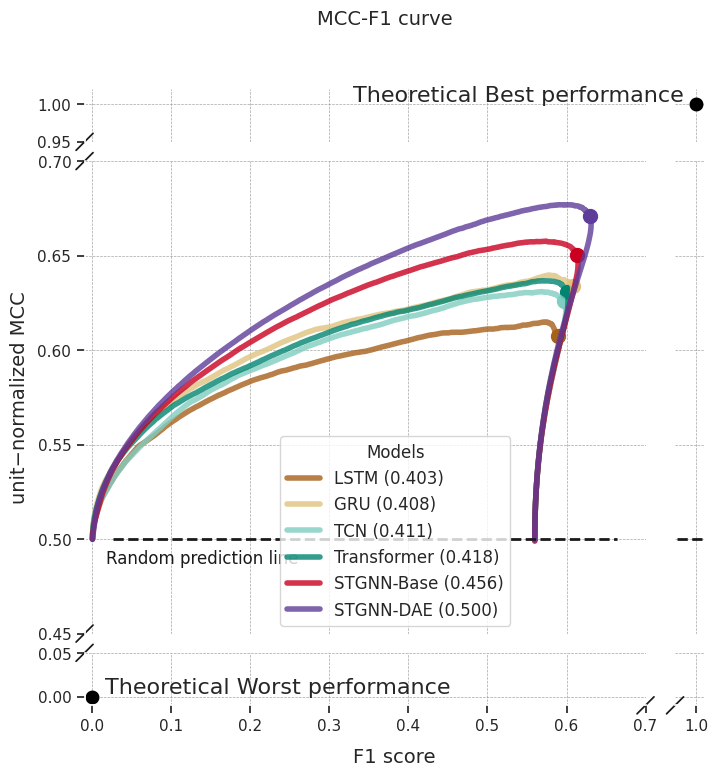

In [31]:
# Plot the results for comparison
plotting_models_comparison(reordered_dict, metrics_results)

In [32]:
# Plot the results for comparison
# plotting_models_comparison(reordered_dict_subset, metrics_results_subset)

In [33]:
#### get F1 and MCC based on thresold

In [34]:
# Provided threshold information for each model
thresholds = {
    'LSTM': {'MCC_F1_Met': 0.40286455863368265, 'Best_threshold': 344, 'threshold_value': 0.31839330590612536},
    'GRU': {'MCC_F1_Met': 0.40826479155187734, 'Best_threshold': 312, 'threshold_value': 0.2991407973350616},
    'TCN': {'MCC_F1_Met': 0.410667766980539, 'Best_threshold': 340, 'threshold_value': 0.33931876305539616},
    'Transformer': {'MCC_F1_Met': 0.4179551136288472, 'Best_threshold': 350, 'threshold_value': 0.3362830222795929},
    'STGNN-Baseline': {'MCC_F1_Met': 0.45612878287446923, 'Best_threshold': 386, 'threshold_value': 0.3863840379291861},
    'STGNN-DAE': {'MCC_F1_Met': 0.5002120266942964, 'Best_threshold': 389, 'threshold_value': 0.38938934297055694},

}

# Mapping model names to their prediction arrays
models = {
    'GRU': y_pred1,
    'LSTM': y_pred2,
    'TCN': y_pred3,
    'Transformer': y_pred4,
    'STGNN-Baseline': y_pred5,
    'STGNN-DAE': y_pred6,
}

# Calculate and print the F1 score and MCC for each model
for model_name, preds in models.items():
    # Use the provided threshold value for each model
    thresh = thresholds[model_name]['threshold_value']
    # Convert continuous outputs to binary predictions
    binary_preds = (preds >= thresh).astype(int)
    # Calculate F1 score and MCC
    f1 = f1_score(y_true, binary_preds)
    mcc = matthews_corrcoef(y_true, binary_preds)
    print(f"{model_name} (Threshold: {thresh}): F1 Score = {f1:.4f}, MCC = {mcc:.4f}")

GRU (Threshold: 0.2991407973350616): F1 Score = 0.6077, MCC = 0.2682
LSTM (Threshold: 0.31839330590612536): F1 Score = 0.5893, MCC = 0.2151
TCN (Threshold: 0.33931876305539616): F1 Score = 0.5972, MCC = 0.2515
Transformer (Threshold: 0.3362830222795929): F1 Score = 0.6002, MCC = 0.2612
STGNN-Baseline (Threshold: 0.3863840379291861): F1 Score = 0.6133, MCC = 0.3008
STGNN-DAE (Threshold: 0.38938934297055694): F1 Score = 0.6301, MCC = 0.3416
